In [92]:

import sys
sys.path.append("../../")

import math
import scipy
import torch
import matplotlib.pyplot as plt
import numpy as np
import implicitmodules.torch as dm

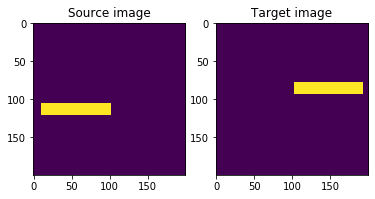

In [48]:

source_image = dm.Utilities.load_greyscale_image("../../data/images/cross_+.png")
target_image = dm.Utilities.load_greyscale_image("../../data/images/cross_x.png")
source_image = dm.Utilities.load_greyscale_image("../../data/images/bar_a.png")
target_image = dm.Utilities.load_greyscale_image("../../data/images/bar_b.png")

plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image)

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image)

plt.show()

In [70]:
sig_smooth = 5
im0 = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
im1 = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

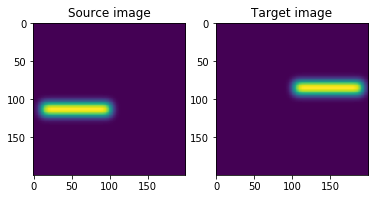

In [71]:

plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(im0)

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(im1)

plt.show()

In [74]:

center = torch.tensor([[10., 13.]])

rotation = dm.DeformationModules.LocalRotation(2, 35., gd=center.clone().requires_grad_())
translation = dm.DeformationModules.ImplicitModule0(2, 1, 300, nu=0.1, gd=center.clone().requires_grad_())


In [75]:
model = dm.Models.ModelImageRegistration(im0, [translation], dm.Attachment.EuclideanPointwiseDistanceAttachment(), fit_gd=[True], lam=100.)

In [76]:

shoot_solver='rk4'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')

In [77]:
#fitter.fit(target_image.clone(), 100, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})
fitter.fit(im1.clone(), 100, costs=costs, options={'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 29083.388671875, 'total': 29083.388671875}


../../implicitmodules/torch/Models/optimizer_scipy.py:43: OptimizeWarning: Unknown solver options: line_search_fn
  scipy_res = minimize(self.__evaluate(target, shoot_solver, shoot_it), x0, method=self.__scipy_method, jac=self.__need_grad, tol=tol, callback=_post_iteration_callback, options=options)


Time: 3.5823798699857434
Iteration: 0
Costs
deformation=499.41058349609375
attach=20197.232421875
total=20696.642578125
Time: 4.450171997988946
Iteration: 1
Costs
deformation=468.2892150878906
attach=20170.060546875
total=20638.349609375
Time: 5.757375970992143
Iteration: 2
Costs
deformation=2182.4970703125
attach=14471.8173828125
total=16654.314453125
Time: 8.09970469099062
Iteration: 3
Costs
deformation=4738.69287109375
attach=9886.8583984375
total=14625.55078125
Time: 8.971159597989754
Iteration: 4
Costs
deformation=5258.0361328125
attach=8872.990234375
total=14131.0263671875
Time: 10.235794226988219
Iteration: 5
Costs
deformation=5463.70458984375
attach=4782.39990234375
total=10246.1044921875
Time: 11.17314272999647
Iteration: 6
Costs
deformation=5282.25390625
attach=4733.27490234375
total=10015.529296875
Time: 12.259801025997149
Iteration: 7
Costs
deformation=5199.912109375
attach=4789.97998046875
total=9989.892578125
Time: 12.695668416999979
Iteration: 8
Costs
deformation=5194.11

Fitted rotatation center: [[9.999957084655762, 12.99976634979248]]


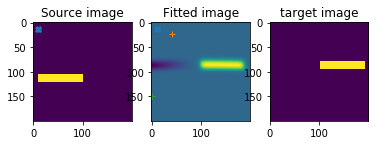

In [95]:

with torch.autograd.no_grad():
    deformed_image = model.compute_deformed(shoot_solver, shoot_it)

fitted_center = model.init_manifold[1].gd.detach()
depl = fitted_center + 10000 *model.init_manifold[1].cotan.detach()
test = np.array([[0, 150]])
print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image)
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image)
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.plot(depl.numpy()[0, 0], depl.numpy()[0, 1], '+')
plt.plot(test[0, 0], test[0, 1], '+')

plt.subplot(1, 3, 3)
plt.title("target image")
plt.imshow(target_image)

plt.show()



In [97]:


from implicitmodules.torch.Models import Model
from implicitmodules.torch.Utilities import sample_from_greyscale, deformed_intensities, AABB
from implicitmodules.torch.DeformationModules import SilentLandmarks, CompoundModule
from implicitmodules.torch.HamiltonianDynamic import shoot, Hamiltonian



In [102]:
model.init_manifold.gd

[tensor([[  0.5000, 199.5000],
         [  1.5000, 199.5000],
         [  2.5000, 199.5000],
         ...,
         [197.5000,   0.5000],
         [198.5000,   0.5000],
         [199.5000,   0.5000]], requires_grad=True),
 tensor([[10.0000, 12.9998]], requires_grad=True)]

In [100]:

compound = CompoundModule(model.modules)
compound.manifold.fill_gd([manifold.gd for manifold in model.init_manifold])
compound.manifold.fill_cotan([manifold.cotan for manifold in model.init_manifold])

# # Forward shooting
shoot(Hamiltonian(compound), shoot_solver, 10)


In [105]:
compound.manifold.gd

[tensor([[ 76.9917, 224.1329],
         [ 78.0059, 224.1374],
         [ 79.0194, 224.1418],
         ...,
         [274.6872,  25.3557],
         [275.5439,  25.3095],
         [276.4001,  25.2632]], grad_fn=<ViewBackward>),
 tensor([[102.4719,  42.7793]], grad_fn=<ViewBackward>)]

In [103]:
model.init_manifold.gd

[tensor([[  0.5000, 199.5000],
         [  1.5000, 199.5000],
         [  2.5000, 199.5000],
         ...,
         [197.5000,   0.5000],
         [198.5000,   0.5000],
         [199.5000,   0.5000]], requires_grad=True),
 tensor([[10.0000, 12.9998]], requires_grad=True)]

In [104]:
model.init_manifold.cotan

[tensor([[0.0027, 0.0009],
         [0.0027, 0.0009],
         [0.0027, 0.0009],
         ...,
         [0.0026, 0.0008],
         [0.0026, 0.0008],
         [0.0026, 0.0008]], requires_grad=True),
 tensor([[0.0032, 0.0011]], requires_grad=True)]

In [83]:
model.init_manifold[1].cotan

tensor([[0.0032, 0.0011]], requires_grad=True)

In [90]:
translation.manifold.cotan

tensor([[-0.0032, -0.0011]])

In [91]:
translation.controls

tensor([[-92.3637, -30.1157]], grad_fn=<DivBackward0>)